# 43. 신경망

- 이번 단계에서는 이전 단계의 코드를 수정하여 신경망으로 '진화'시킬 것입니다. 
- 우선 이전 단계에서 수행한 변환을 DeZero의 linear 함수로 구현하는 일부터 시작하겠습니다. 

## 43.1 DeZero의 linear 함수

- 이전 단계에서는 간단한 데이터셋을 대상으로 선형 회귀를 구현했지만, 그 선형회귀로 수행한 계산은 (손실 함수를 제외하면) '행렬의 곱'과 '덧셈'뿐이었습니다. 해당 코드를 발췌하면 다음과 같습니다. 

```y = F.matmul(x, W) + b```

- 이와 같이 입력 x와 매개변수 W 아시에서 행렬 곱을 구하고, 거기에 b를 더합니다. 
- 이 변환을 선형 변환(linear transformation) 혹은 아핀 변환(affine transformation)이라고 합니다. 
    - 신경망 분야에서는 b를 더하는 계산까지 포함한 연산을 선형 변환이라고 합니다. 
    - 선형 변환은 신경망에서는 완전연결계층(fully connected layer)에 해당하며, 매개변수 W는 가중치(Weight), 매개변수 b는 편향(bias)이라고 합니다. 
- 이번 절에서는 앞의 선형 변환을 linear 함수로 구현하겠습니다. 구현 방법은 두 가지입니다. 
    - 하나는 앞의 코드와 같이 지금까지 구현해 온 DeZero 함수를 사용하는 방식이고, (
    - 다른 하나는 Function 클래스를 상속하여 새롭게 Linear라는 함수 클래스를 구현하는 방식입니다. (후자가 메모리를 더 효율적으로 씁니다.)

![title](image/그림43-1.png)

- 왼쪽 방식은 matmul 함수의 출력은 Variable 인스턴스이므로 계산 그래프에 기록됩니다. 즉, Variable 인스턴스와 그 안에 담긴 데이터(ndarry 인스턴스)는 계산 그래프가 존재하는 동안은 계속 메모리에 머물게 됩니다. 

- 오른쪽 그림은 Function 클래스를 상속하여 Linear 클래스를 구현하는 방식입니다. 이 방식에서는 중간 결과가 Variable 인스턴스로 보존되지 않기 때문에 순전파 시 사용하던 중간 데이터는 순전파가 끝나는 즉시 삭제됩니다. 따라서 DeZero를 제3자에게 제공할 생각이라면 메모리 효율 관점에서 오른쪽 방식을 채용하면서 메모리 효율도 개선할 수 있는 '묘수'가 있습니다. 

- 이제부터 그 묘수에 대해서 설명합니다. 

- 왼쪽 방식의 역전파 시에 +의 역전파는 출력 쪽의 기울기를 단순히 흘려보내기만 합니다. 즉, t의 데이터는 + 역전파에 필요하지 않습니다. 다음으로 matmul 역전파는 입력, x, W, b만 사용합니다. 따라서 matmul 역전파 또한 t의 데이터를 필요로 하지 않습니다. 
- 이상으로부터 변수 t의 데이터는 역전파 시 아무에게도 필요하지 않다는 사실을 알 수 있습니다. 즉, 기울기를 흘려보내야 하므로 계산 그래프에서는 변수 t가 필요하지만, 그 안의 데이터는 즉시 지워도 됩니다. 아래처럼 구현할 수 있습니다. 

In [1]:
def linear_simple(x, W, b=None):
    t = matmul(x, W) # x와 W는 Variable 인스턴스 혹은 ndarry 인스턴스라고 가정. ndarray 인스턴스라면 Variable 인스턴스로 변환됨.
    if b is None:  # 편향이 없으면 단순히 행렬 곱셈만 계산하여 그 결과를 반환합니다. 
        return t

    y = t + b      # 편향이 주어지면 단순히 더해줍니다. 
    t.data = None  # t의 데이터 삭제. 참조 카운트가 0이 되어 파이썬 인터프리터에 의해 삭제됨. 신경망에서 메모리 대부분을 차지하는 것이
    return y       # 중간 계산 결과인 텐서(ndarry 인스턴스)이므로, 큰 텐서를 취급하는 경우 즉시 삭제하는 것이 바람직합니다. 

In [3]:
from dezero.core import Function
class Linear(Function):
    def forward(self, x, W, b):
        y = x.dot(W)
        if b is not None:
            y += b
        return y

    def backward(self, gy):
        x, W, b = self.inputs
        gb = None if b.data is None else sum_to(gy, b.shape)
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW, gb


def linear(x, W, b=None):
    return Linear()(x, W, b)

## 43.2 비선형 데이터셋

- 이전 단계에서는 직선상에 나열된 데이터셋을 사용했는데, 이번 절에서는 더 복잡한 데이터셋에 도전하겠습니다. 

In [4]:
import numpy as np

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

- 보다시피 sin 함수를 사용하여 데이터를 생성했습니다. 
- 이렇게 생성한 (x,y) 점들을 2차원 평면에 그리면 아래와 같이 됩니다. 

![title](image/그림43-2.png)

- 보시다시피 x와 y는 선형관계가 아닙니다. 이러한 비선형 데이터셋은 당연히 선형 회귀로는 풀 수 없습니다. 
- 신경망이 해결사로 등장하는 순간이죠.

## 43.3 활성화 함수와 신경망

- 선형 변환은 이름 그대로 입력 데이터를 선형으로 변환해줍니다. 
- 한편 신경망은 선형 변환의 출력에 비해 비선형 변환을 수행합니다. 
- 이 비선형 변환을 활성화 함수(activation function)라고 하며, 대표적으로 ReLU 함수와 시그모이드 함수 등이 있습니다. 
- 여기에서는 활성화 함수로 시그모이드 함수를 사용합니다. 시그모이드 함수는 아래 식으로 표현되면 그래프는 다음과 같습니다. 

![title](image/식43.1.png)

![title](image/그림43-3.png)

- 위 그림에서와 같이 시그모이드 함수는 비선형입니다. 이 비선형 변환이 텐서의 각 원소에 적용됩니다. 
- 다음은 DeZero를 사용하여 구현한 시그모이드 함수입니다. 

In [6]:
def sigmoid_simple(x):
    x = as_variable(x)
    y = 1 / (1 + exp(-x))
    return y

- 이와 같이 수식을 그대로 코드로 옮기면 됩니다. 지수 함수로 DeZero의 exp 함수를 사용한다는 점만 유의하면 특별히 어려운 점은 없습니다. 
- 여기에서 제시한 시그모이드 함수도 메모리 효율이 좋지 않습니다. 
- 더 나은 방식은 Function 클래스를 상속한 Sigmoid 클래스를 구현하는 것입니다. 
    - 클래스를 하나의 단위로 하여 기울기 계산 효율을 높일 수 있습니다. 

In [8]:
class Sigmoid(Function):
    def forward(self, x):
        xp = cuda.get_array_module(x)
        # y = 1 / (1 + xp.exp(-x))
        y = xp.tanh(x * 0.5) * 0.5 + 0.5  # Better implementation
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = gy * y * (1 - y)
        return gx


def sigmoid(x):
    return Sigmoid()(x)

## 43.4 신경망 구현

- 일반적인 신경망은 '선형 변환 → 활성화 함수 → 선형 변환 → 활성화 함수 → 선형 변환 →...' 형태로 연속적으로 변환을 수행합니다. 
- 예를 들어 2층 신경망은 다음처럼 구현할 수 있습니다. 

In [11]:
from dezero import Variable

I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))


def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

- 이와 같이 '선형 변환'과 '활성화 함수'를 순서대로 적용합니다. 
- 이것이 신경망 추론(predict) 코드입니다. 
- 물론 이 추론을 제대로 하려면 '학습'이 필요합니다. 
- 신경망 학습에서는 추론을 처리한 후 손실 함수를 추가하고, 손실 함수의 출력을 최소화하는 매개변수를 찾습니다. 
- 이것이 신경망 학습입니다. 신경망에서는 선형 변환이나 활성화 함수 등에 의한 변환을 '층(layer)'라고 합니다. 
- 또한 선형 변환과 같이 매개변수가 있는 층 N개가 연속으로 이어져 N번의 변환을 수행하는 구조를 'N층 신경망'이라고 합니다. 
- 그러면 실제 데이터셋을 활용하여 신경망을 학습시켜 볼까요? 다음은 그 코드입니다. 

variable(0.8473695850105871)
variable(0.2514286285183607)
variable(0.2475948546674987)
variable(0.23786120447054818)
variable(0.21222231333102926)
variable(0.16742181117834143)
variable(0.09681932619992631)
variable(0.07849528290602327)
variable(0.07749729552991153)
variable(0.07722132399559309)


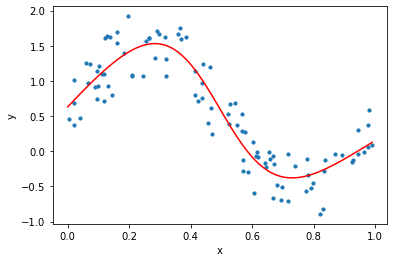

In [12]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

# 데이터셋
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# (1) 가중치 초기화
# 입력층 차원수(Input layer)=1, 은닉층 차원수(Hidden layer)=10, 출력층 차원수(Output layer)=1
# b 편향은 0 벡터로 초기화, W 가중치는 작은 무작위 값으로 초기화
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

# (2) 신경망 추론
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y


lr = 0.2
iters = 10000

# (3) 신경망 학습
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print(loss)


# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

- 학습을 마친 신경망은 아래 그램의 곡선을 예측합니다. 

![title](image/그림43-4.png)

- 위와 같이 sin 함수의 곡선을 잘 표현하고 있습니다. 
- 보다시피 선형 회귀의 구현에 활성화 함수와 선형 변환을 거듭 적용하여 비선형 관계도 제대로 학습할 수 있었습니다.

- 이 구현 방식을 그대로 적용하면 더 깊은 신경망도 구현할 수 있습니다. 
- 하지만 층이 깊어질수록 매개변수 관리(매개변수의 기울기를 재설정하거나 매개변수를 갱신하는 등의 작업)가 번거로워집니다. 
- 그래서 다음 단계에서는 매개변수 관리를 간소화하는 구조를 만들려 합니다. 

# 44. 매개변수를 모아두는 계층

- 사용 편의성 측면에서 문제를 해결해 보자
- 이번 단계에서는 매개변수를 다루어봅니다. 
    - 매개변수는 경사하강법 등의 최적화 기법에서 갱신되는 변수입니다. 이전 단계의 예에서는 선형 변환에 사용되는 '가중치'와 '편향'이 매개변수에 해당합니다. 
- 이번 단계에서는 매개변수를 담는 구조를 만듭니다. 이를 위해 Parameter와 Layer라는 클래스를 구현합니다. 
    - 이 두 클래스를 사용하면 매개변수 관리를 자동화할 수 있습니다. 

## 44.1 Parameter 클래스 구현

- Parameter 클래스는 Variable 클래스와 똑같은 기능을 갖게 합니다. 그래서 다음과 같이 구현합니다. 
- 보시다시피 Variable 클래스를 상속한 게 다라서 기능도 Variable 클래스와 동일합니다. 
- Parameter 클래스는 dezero/core.py에 추가합니다. 
- 그리고 dezero/\_\_init\_\_.py에 from dezero.core import Parameter라는 한 줄을 추가합니다. 
- 그러면 DeZero를 사용하는 사람은 from dezero import Parameter로 임포트 할 수 있습니다. 

In [14]:
class Parameter(Variable):
    pass

- Parameter 인스턴스와 Variable 인스턴스는 기능은 같지만 구별할 수는 있습니다. 구체적인 예를 볼까요?

In [15]:
import numpy as np
from dezero import Variable, Parameter

x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


- 이와 같이 Parameter 인스턴스와 Variable 인스턴스를 조합하여 계산할 수 있습니다. 
- 그리고 isinstance 함수로 구분할 수 있습니다. 
- 이 점을 이용하여 Parameter 인스턴스만을 담는 구조를 만들 수 있습니다. 

## 44.2 Layer 클래스 구현

- Layer는 DeZero의 Function 클래스와 마찬가지로 변수를 변환하는 클래스입니다. 
- 그러나 매개변수를 유지한다는 점이 다릅니다. 
- Layer 클래스는 매개변수를 유지하고 매개변수를 사용하여 변환을 하는 클래스입니다. 

- Layer 클래스를 기반 클래스로 두고 구체적인 변환은 자식 클래스에서 구현합니다. 
- 예를 들어 선형 변환은 Layer 클래스를 상속한 Linear 클래스에서 구현합니다. 

- Layer 클래스를 구현해 보겠습니다. 우선 초기화와 \_\_setattr\_\_ 특수 메서드를 살펴보시죠.

In [17]:
from dezero.core import Parameter

class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):
            self._params.add(name)
        super().__setattr__(name, value)

- Layer 클래스에는 \_params라는 인스턴스 변수가 있습니다. \_params에는 Layer 인스턴스에 속한 매개변수를 보관합니다. 
    - 인스턴스 변수 \_params의 타입은 '집합(set)'입니다. 
    - 집합은 리스트와 달리 원소들에 순서가 없고, ID가 같은 객체는 중복 저장할 수 없습니다. 
- \_\_setattr\_\_은 인스턴스 변수를 설정할 때 호출되는 특수 메서드입니다. 
- \_\_setattr\_\_(self, name, value)는 이름이 name인 인스턴스 변수에 값으로 value를 전달해 줍니다. 
- 이 메서드를 재정의(override)하면 인스턴스 변수를 설정할 때 여러분만의 로직을 추가할 수 있습니다. 
- 여기에서는 value가 Parameter 인스턴스라면 self._params에는 (value가 아니라) name을 추가합니다. (매개변수를 외부 파일로 저장할 때 name을 유지하는 쪽이 편리하기 때문입니다. 해당 작업은 53단계에서 수행합니다. )
- 이렇게 하여 Layer 클래스가 갖는 매개변수를 인스턴스 변수 \_params에 모아둘 수 있습니다. 
- 다음은 예시 코드입니다. 

In [22]:
layer = Layer()

layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)
print('------------')

for name in layer._params:
    print(name, layer.__dict__[name])


{'p2', 'p1'}
------------
p2 variable(2)
p1 variable(1)


- 이와 같이 layer 인스턴스 변수를 설정하면 Parameter 인스턴스를 보유하고 있는 인스턴스 변수 이름만 layer.\_params에 추가됩니다. 
- 또한 인스턴스 변수 \_\_dict\_\_에는 모든 인스턴스 변수가 딕셔너리(dictionary) 타입으로 저장되기 때문에 Parameter 인스턴스만 꺼낼 수 있습니다. 

- 그런 다음 Layer 클래스에 다음 4개의 메서드를 추가합니다. 

In [23]:
import weakref

class Layer:
    ...
    
    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, inputs):
        raise NotImplementedError()

    def params(self):
        for name in self._params:
            yield self.__dict__[name]

    def cleargrads(self):
        for param in self.params():
            param.cleargrad()

- \_\_call\_\_메서드는 입력받은 인수를 건네 forward 메서드를 호출합니다. 
- forward 메서드는 자식 클래스에서 구현할 것입니다. 
- \_\_call\_\_메서드는 출력이 하나뿐이라면 튜플이 아니라 그 출력을 직접 반환합니다.(Function 클래스와 똑같은 관계를 따랐습니다.)
- 또한 나중을 생각하여 입력과 출력 변수를 약한 참조로 유지하고 있습니다. 

- params 메서드는 Layer 인스턴스에 담겨 있는 Parameter 인스턴스들을 꺼내주고, cleargrads 메서드는 모든 매개변수의 기울기를 재설정합니다. 
- 참고로 cleargrads의 이름 끝에 's'를 붙여 '복수'형으로 만들었는데, 이는 Layer가 가진 '모든' 매개변수에 대해(단수형인) cleargrad를 호출한다는 사실을 명시한 것입니다. 
- params 메서드는 yield를 사용하여 값을 반환합니다. yield는 return 처럼 사용할 수 있습니다. 
- 다만 return은 처리를 종료하고 값을 반환하는 반면 yield는 처리를 '일시중지(suspend)'하고 값을 반환합니다. 
- 따라서 yield를 사용하면 작업을 '재개(resume)'할 수 있습니다. 
- 앞의 예로 말하자면 params 메서드를 호출할 때마다 일시 중지됐던 처리가 재개됩니다. 
- 이런 식으로 (yield를 for 문과 함께 사용하여) 매개변수를 순차적으로 꺼낼 수 있습니다. 

- 이상으로 Layer 클래스의 구현을 마칩니다. 
- 이제부터 Layer 클래스를 상속하여 선형 변환 등의 구체적인 처리를 구현할 것입니다. 

## 44.3 Linear 클래스 구현

- 이어서 선형 변환을 하는 Linear 클래스를 구현하겠습니다. (함수로서의 Linear 클래스가 아니라 계층으로서의 Linear 클래스를 구현합니다.)
- 먼저 간단한 Linear 클래스를 보여드린 후 개선하는 식으로 진행하겠습니다. 다음 코드를 살펴보시죠.

In [24]:
import numpy as np
import dezero.functions as F
from dezero.core import Parameter

class Linear(Layer):
    def __init__(self, out_size, nobias=False, dtype=np.float32):
        super().__init__()

        I, O = in_size, out_size
        W_data = np.random.randn(I, O).astype(dtype) * np.sqrt(1 / I)  # 가중치 초깃값은 무작위로 설정합니다. 
        self.W = Parameter(W_data, name='W')
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(0, dtype=dtype), name='b')

    def forward(self, x):
        y = F.linear(x, self.W, self.b)
        return y

- Linear 클래스는 Layer 클래스를 상속하여 구현합니다. 
- \_\_init\_\_(self, in_size, out_size, nobias)의 인수는 차례로 '입력 크기', '출력 크기', '편향 사용 여부 플래그'입니다. nobias가 True면 편향을 생략합니다. 

- 이 때 가중치와 편향은 self.W = Parameter(...)와 self.b = Parameter(...) 형태로, Parameter 인스턴스를 인스턴스 변수에 설정합니다. 이렇게 함으로써 두 Parameter 인스턴스 변수의 이름이 self.\_params에 추가됩니다. 

- 이어서 forward 메서드로 선형 변환을 구현했습니다. 
- 이 메서드는 DeZero의 linear 함수를 호출할 뿐입니다. 이상이 Linear 클래스의 구현입니다. 

- 그런데 앞서 언급했듯이 Linear 클래스를 구현하는 더 나은 방법이 있습니다. 
- 바로 가중치 W를 생성하는 시점을 늦추는 방식입니다. 
- 구체적으로는 가중치를 (초기화 메서드가 아닌) forward 메서드에서 생성함으로써 Linear 클래스의 입력 크기(in_size)를 자동으로 결정할 수 있습니다. (사용자가 지정하지 않아도 됩니다.) 개선된 버전의 Linear 클래스를 만나보시죠.

In [ ]:
import numpy as np
import dezero.functions as F
from dezero.core import Parameter

class Linear(Layer):
    def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if self.in_size is not None:     # in_size가 지정되어 있지 않다면 나중으로 연기
            self._init_W()

        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')

    def _init_W(self, xp=np):
        I, O = self.in_size, self.out_size
        W_data = xp.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W.data = W_data

    def forward(self, x):
        # 데이터를 흘려보내는 시점에 가중치 초기화
        if self.W.data is None:
            self.in_size = x.shape[1]
            xp = cuda.get_array_module(x)
            self._init_W(xp)

        y = F.linear(x, self.W, self.b)
        return y

- 이것이 개선된 Linear 클래스입니다. 주목할 점은 \_\_init\_\_메서드 in_size를 지정하지 않아도 된다는 것입니다. 
- 인수 in_size는 기본적으로 None으로 지정되어 있으며, None인 경우 self.W.data 초기화를 '연기'합니다. 
- forward(self, x) 메서드에서 입력 x의 크기에 맞춰 가중치 데이터를 생성하는 것이죠.
- 이제 layer=Linear(100)처럼 출력 크기만 지정해도 되므로 사용성이 좋아졌습니다. 이상이 Linear 클래스의 구현입니다. 

## 44.4 Layer를 이용한 신경망 구현

- 다음은 Linear 클래스를 이용하여 신경망을 구현해볼 차례입니다. 
- 이전 단계에서 푼 문제, 즉 sin 함수의 데이터셋에 대한 회귀 문제를 다시 풀어봅시다. 
- 이전 단게에서 달라진 부분은 음영으로 표시했습니다. 

In [ ]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import dezero.functions as F
import dezero.layers as L  # L로 임포트

# 데이터셋
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)      # 출력 크기 지정
l2 = L.Linear(1)       # 달라진 부분


def predict(x):
    y = l1(x)          # 달라진 부분
    y = F.sigmoid(y)
    y = l2(y)          # 달라진 부분
    return y


lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    l1.cleargrads()   # 달라진 부분
    l2.cleargrads()   # 달라진 부분
    loss.backward()

    for l in [l1, l2]:                   # 달라진 부분
        for p in l.params():             # 달라진 부분
            p.data -= lr * p.grad.data   # 달라진 부분
    if i % 1000 == 0:
        print(loss)

- 주목할 점은 매개변수 관리를 Linear 인스턴스가 맡고 있다는 것입니다. 
- 그 덕분에 매개변수 기울기 재설정과 매개변수 갱신 작업이 전보다 깔끔해졌습니다. 

- 그러나 Linear 클래스를 개별적으로 다루는 부분이 눈에 밟힙니다. 
- 앞으로 더욱 '깊은' 신경망을 다룰 것을 생각하면 분명 걸림돌이 될 거 같습니다. 
- 그래서 다음 단게에서는 여러 Layer를 하나의 클래스로 묶어서 관리하도록 개선하겠습니다. 

# 45. 계층을 모아두는 계층 

- 이전 단계에서는 Layer 클래스를 만들었습니다. 
- Layer 클래스에는 매개변수를 관리하는 구조가 녹아 있어서 Layer 클래스를 사용하면 매개변수를 우리가 직접 다루지 않아도 되어 편리합니다. 
- 그런데 Layer 인스턴스 자체도 관리는 필요합니다. 
- 예를 들어 10층 신경망을 구현하려면 10개의 Layer 인스턴스를 관리해야 합니다. (귀찮은 일이죠)
- 그래서 그런 부담을 줄일 수 있도록 현재의 Layer 클래스를 확장하겠습니다. 

## 45.1 Layer 클래스 확장

- 현재 Layer 클래스는 여러 개의 Parameter를 가질 수 있습니다. 여기에 더해서 Layer 클래스가 '다른 Layer'도 담을 수 있게 확장하려 합니다.
- 아래 그림과 같은 관계로 만드는 것입니다. 

![title](image/그림45-1.png)

- 위 그림처럼 Layer 안에 다른 Layer가 들어가는 구조입니다. 
- '상자' 구조라 할 수 있죠. 이번 단계의 목표는 위 그림의 바깥 Layer에서 그 안에 존재하는 모든 매개변수를 꺼낼 수 있도록 하는 것입니다. 
- 이를 위해 현재의 Layer 클래스를 다음과 같이 변경합니다. 

In [25]:
class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):  # (1) Layer도 추가
            self._params.add(name)
        super().__setattr__(name, value)

    def params(self):
        for name in self._params:
            obj = self.__dict__[name]

            if isinstance(obj, Layer):   # (2) Layer에서 매개변수 꺼내기
                yield from obj.params()
            else:
                yield obj

- 첫 번째 변화로 인스턴스 변수를 설정할 때 Layer 인스턴스의 이름도 \_params에 추가하도록 합니다. 따라서 Parameter 인스턴스와 Layer 인스턴스의 이름이 \_params에 추가됩니다. 

- 두 번째 변경점은 매개변수를 꺼내는 처리입니다. params 메서드는 \_params에서 name(문자열)을 꺼내 그 name에 해당하는 객체를 obj로 꺼냅니다. 이때 obj가 Layer 인스턴스라면 obj.params()를 호출합니다. 이런 식으로 Layer 속 Layer에서도 매개변수를 재귀적으로 꺼낼 수 있습니다. 

- yield를 사용한 함수를 제너레이터(generator)라고 합니다. 제너레이터를 사용하여 또 다른 제너레이터를 만들고자 할 때는 yield from을 사용합니다. yield from은 파이썬 3.3부터 지원합니다. 

- 이것으로 새로운 Layer 클래스를 완성했습니다. 새로운 Layer 클래스를 사용하면 신경망을 다음 코드처럼 구현할 수 있습니다. 

In [27]:
import dezero.layers as L
import dezero.functions as F
from dezero import Layer

model = Layer()
model.l1 = L.Linear(5)  # 출력 크기만 지정
model.l2 = L.Linear(3)

# 추론을 수행하는 함수
def predict(model, x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

# 모든 매개변수에 접근
for p in model.params():
    print(p)
    
# 모든 매개변수의 기울기를 재설정
model.cleargrads()

variable(None)
variable([0. 0. 0.])
variable(None)
variable([0. 0. 0. 0. 0.])


- 먼저 model = Layer()에서 인스턴스를 생성한 다음 model의 인스턴스 변수로 Linear 인스턴스를 추가합니다. 
- 그러면 추론을 수행하는 함수를 predict(model, x)로 구현할 수 있습니다. 
- 여기서 중요한 점은 model.params()로 model 내에 존재하는 모든 매개변수에 접근할 수 있다는 것입니다. 
- 또한 model.cleargrads()는 모든 매개변수의 기울기를 재설정합니다. 
- 이처럼 Layer 클래스를 이용하여 신경망에서 사용하는 매개변수를 한꺼번에 관리할 수 있습니다. 
- 한편 Layer 클래스를 더 편리하게 사용하는 방법도 있습니다. 
- 바로 Layer 클래스를 상속하여 모델 전체를 하나의 '클래스'로 정의하는 방법이죠. 준비한 예를 볼까요?

In [29]:
class TwoLayerNet(Layer):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

- TwoLayerNet이라는 이름으로 클래스 모델을 정의했습니다. 
- 이 클래스는 Layer를 상속했고 \_\_init\_\_와 forward 메서드를 구현했습니다. 
- \_\_init\_\_메서드에서는 필요한 Layer들을 생성하여 self.l1 = ... 형태로 설정해둡니다.
- 한편 forward 메서드에는 추론을 수행하는 코드를 작성했습니다. 
- 이처럼 TwoLayerNet이라는 클래스 하나에 신경망에 필요한 모든 코드를 집약할 수 있습니다. 
- 여기에서 선보인 객체지향 모델 정의 방법(모델을 클래스 단위로 정의)은 체이너가 최초로 제안했고, 그 후 파이토치와 텐서플로 등 많은 다른 프레임워크에서 보편적으로 사용하는 방식으로 굳어졌습니다. 

## 45.2 Model 클래스

- 모델은 '사물의 본질을 단순하게 표현한 것'이라는 뜻인데, 머신러닝에 사용되는 모델도 마찬가지입니다. 
- 복잡한 패턴이나 규칙이 숨어 있는 현상을 수식을 사용하여 단순하게 표현한 것을 말하죠.
- 신경망도 수식으로 표현할 수 있는 함수이며, 그것을 가리켜 '모델'이라고 합니다. 

- 이번 절에서는 모델을 표현하기 위한 Model 클래스를 새로 만듭니다. 
- Model 클래스는 Layer 클래스의 기능을 이어받으며 시각화 메서드가 하나 추가됩니다. 코드는 다음과 같습니다. 

In [31]:
from dezero import Layer
from dezero import utils

class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

- 이와 같이 Model은 Layer를 상속합니다. 따라서 Model 클래스를 앞에서 본 Layer 클래스처럼 활용할 수도 있습니다. 
- 가령 class TwoLayerNet(Model): 이라고 작성할 수 있습니다. 
- 또한 Model 클래스에는 시각화를 위한 plot 메서드가 추가되어 있습니다. 
- plot은 인수 *inputs로 전달받은 데이터를 forward 메서드로 계산한 다음, 이때 생성된 계산 그래프를 이미지 파일로 내보냅니다. 
- 참고로 utils.plot_dot_graph 함수의 인수에 대해 verbose=True로 설정하면 ndarray 인스턴스의 형상과 타입도 계산 그래프에 표시해줍니다. 

- 마지막으로 Model 클래스를 쉽게 임포트할 수 있도록 dezero/\_\_int\_\_.py에 다음 줄을 추가합니다. 
- ```from dezero.models import Model```
- 이제 다음과 같은 코드를 작성할 수 있습니다. 

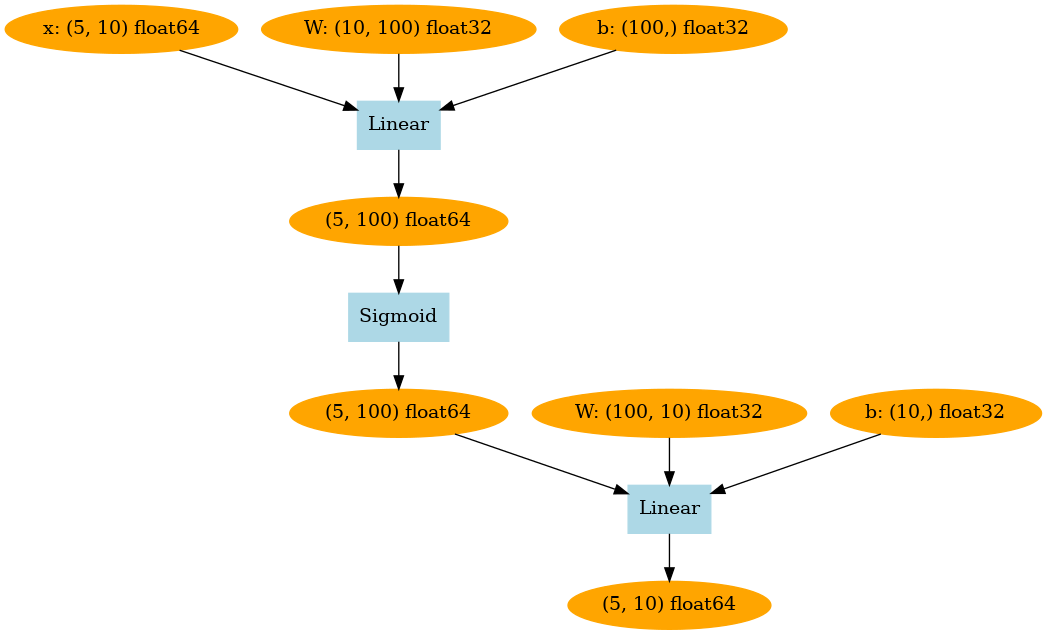

In [32]:
import numpy as np
from dezero import Variable, Model
import dezero.layers as L
import dezero.functions as F


class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

- 보다시피 Model 클래스는 마치 Layer 클래스처럼 활용할 수 있습니다. 
- 여기에 계산 그래프를 시각화해주는 메서드도 제공합니다. 위 코드를 실행하며 아래 그림을 얻을 수 있습니다. 

![title](image/그림45-2.png)

## 45.3 Model을 사용한 문제 해결

- 그러면 sin 함수로 생성한 데이터셋 회귀 문제를 Model 클래스를 이용하여 다시 풀어봅시다. 
- 이전 단계에서 달라진 부분은 음영으로 표시했습니다. 

In [33]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero import Model
import dezero.layers as L
import dezero.functions as F

# 데이터셋 생성
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# Hyperparameters 설정
lr = 0.2
max_iter = 10000
hidden_size = 10

# Model definition 모델 정의 (전체가 달라짐)
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y


model = TwoLayerNet(hidden_size, 1)

# 학습 시작
for i in range(max_iter):
    y_pred = model(x)               # 달라진 부분
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()              # 달라진 부분
    loss.backward()

    for p in model.params():        # 달라진 부분
        p.data -= lr * p.grad.data  # 달라진 부분
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649355)
variable(0.0788816650635515)
variable(0.07655073683421634)
variable(0.07637803086238225)
variable(0.07618764131185571)


- 이와 같이 Model 클래스를 상속한 TwoLayerNet으로 신경망을 구현했습니다. 
- 덕분에 for문 안의 코드가 더 간단해졌습니다. 
- 모든 매개변수는 model을 통해 접근할 수 있으며 매개변수의 기울기 재설정도 model.cleargrads()로 처리했습니다. 
- 이것으로 우리는 매개변수 관리에서 해방되었습니다!
- 앞으로는 아무리 복잡한 신경망을 구축한다 해도 필요한 모든 매개변수를 Model 클래스(또는 Layer 클래스)로 관리할 수 있기 때문입니다. 
- 이번 단계의 주요 목적은 이것을 달성했지만, 다음 단계로 나아가기 전에 더 범용적인 신경망 모델을 하나 구현해봤으면 합니다. 

## 45.4 MLP 클래스

- 방금 층이 2개인 완전연결계층으로 이루어진 모델을 구현했습니다. 해당 코드를 발췌하면 아래와 같습니다. 

In [34]:
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

- 이와 같이 하나의 클래스로 2층 신경망을 구현했습니다. 
- 이번 절에서는 앞으로를 위해 더 범용적인 완전연결계층 신경망을 구현하겠습니다. 코드는 다음과 같습니다. 

In [35]:
import dezero.functions as F
import dezero.layers as L

class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):
        super().__init__()
        self.activation = activation
        self.layers = []

        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)

    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)

- 먼저 초기화에서는 인수로 fc_output_sizes와 activation을 받습니다. 
- 여기서 fc는 full connect(완전연결)의 약자입니다. 
- fc_output_sizes는 신경망을 구성하는 완전연결계층들의 출력 크기를 튜플 또는 리스트로 지정합니다. 
- 가령 (10, 1)을 건네면 2개의 Linear 계층을 만들고, 첫 번째 계층의 출력 크기는 10으로, 두 번째 계층의 출력 크기는 1로 구성합니다. 
- (10, 10, 1)을 건네면 Linear 계층이 하나 늘어나서 총 3개가 되죠. 한편 인수 activation으로는 활성화 함수를 지정합니다. (기본값은 F.sigmoid 함수)
- 클래스 이름인 MLP는 Multi-Layer Perceptron의 약자로 우리말로 '다층 퍼셉트론'이라고 합니다. 
- MLP는 완전연결계층 신경망의 별칭으로 흔히 쓰입니다. 
- MLP 클래스의 구현은 앞서 보여드린 TwoLayerNet 클래스의 자연스러운 확장으로 볼 수 있습니다. 
- 한 가지, 인스턴스 변수 설정을 setattr 함수로 하고 있음에 주의하세요.
- 여기에서는 self.l2=... 형태로 코딩할 수 없기 때문입니다. 
- 또한 DeZero는 계층 모델에 인스턴스 변수를 설정하는 식으로 계층에 포함된 매개변수들을 관리하고 있습니다. 
- 이상이 MLP 클래스입니다. MLP 클래스가 있다면 다음과 같이 'N층' 신경망을 쉽게 구현할 수 있습니다. 

In [37]:
model = MLP((10, 1))  # 2층
model = MLP((10, 20, 30, 40, 1))  # 5층

- MLP 클래스는 범용성이 높아 앞으로도 계속 사용하는 것입니다. 
- 그래서 dezero/models.py에 추가합니다. 이상으로 이번 단계를 마칩니다. 

# 46. Optimizer로 수행하는 매개변수 갱신 

- 지금까지는 경사하강법으로 매개변수를 갱신했습니다. 
- 딥러닝 분야에서는 경사하강법 외에도 다양한 최적화 기법이 제안되고 있습니다. 
- 이번 단계에서는 매개변수 갱신 작업(갱신 코드)을 모듈화하고 쉽게 다른 모듈로 대체할 수 있는 구조를 만들겟습니다. 

## 46.1 Optimizer 클래스

- 이번 절에서는 매개변수 갱신을 위한 기반 클래스인 Optimizer 클래스를 구현합니다. 
- Optimizer가 기초를 제공하고, 구체적인 최적화 기법은 Optimizer 클래스를 상속한 곳에서 구현하게 할 것입니다. 먼저 Optimizer를 만나보시죠.

In [39]:
class Optimizer:
    def __init__(self):
        self.target = None
        self.hooks = []

    def setup(self, target):
        self.target = target
        return self

    def update(self):
        # None 이외의 매개변수 리스트에 모아둠
        params = [p for p in self.target.params() if p.grad is not None]

        # 전처리(옵션)
        for f in self.hooks:
            f(params)

        # 매개변수 갱신    
        for param in params:
            self.update_one(param)

    def update_one(self, param):
        raise NotImplementedError()

    def add_hook(self, f):
        self.hooks.append(f)

- Optimizer 클래스의 초기화 메서드에서는 target과 hooks라는 두 개의 인스턴스 변수를 초기화 합니다. 
- 그리고 setup 메서드는 매개변수를 갖는 클래스(Model 또는 Layer)를 인스턴스 변수인 target으로 설정합니다. 

- 한편 update 메서드는 모든 매개변수를 갱신합니다. 하지만 인스턴스 변수 grad가 None인 매개변수는 갱신을 건너뜁니다. 
- 그리고 구체적인 매개변수 갱신은 update_one 메서드에서 수행하는데, 바로 이 메서드를 Optimizer의 자신 클래스에서 재정의해야 합니다. 

- 또한 Optimizer 클래스는 매개변수 갱신에 앞서 전체 매개변수를 전처리해주는 기능도 갖췄습니다. 
- 원하는 전처리가 있다면 add_hook 매서드를 사용하여 전처리를 수행하는 함수를 추가합니다. 
- 이 구조 덕에 가중치 감소(Weight Decay)와 기울기 클리핑(Gradient Clipping) 같은 기법을 이용할 수 있습니다. (구현 예는 example/mnist.py 등을 참고하세요)

## 46.2 SGD 클래스 구현

- 그러면 경사하강법으로 매개변수를 갱신하는 클래스를 구현해보겠습니다. 다음은 SGD라는 이름의 클래스 코드입니다. 

In [41]:
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        super().__init__()
        self.lr = lr

    def update_one(self, param):
        param.data -= self.lr * param.grad.data

- SGD 클래스는 Optimizer 클래스를 상속합니다. \_\_init\_\_ 메서드는 학습률을 받아 초기화하고 update_one 메서드에서 매개변수 갱신 코드를 구현합니다. 이것으로 매개변수 갱신을 SGD 클래스에 맡길 수 있습니다. SGD 클래스는 dezero/optimizers.py에 담겨 있으니, 외부 파일에서는 from dezero.optimizers import SGD로 임포트할 수 있습니다. 
- SGD(Stochastic Gradient Descent)은 확률적 경사 하강법의 약자입니다. 여기에서 '확률적'은 대상 데이터 중에서 무작위로(확률적으로) 선별한 데이터에 대해 경사하강법을 수행한다는 뜻입니다. 딥러닝에서는 이처럼 원래의 데이터에서 무작위로 골라 경사하강법을 수행하는 것이 일반적입니다. 

## 46.3 SGD 클래스를 사용한 문제 해결

- SGD 클래스를 사용하여 이전 단계와 똑같은 문제를 풀어봅시다. 마찬가지로 이전 단계에서 달라진 부분은 음영으로 표시했습니다. 

In [42]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero import optimizers # 달라진 부분
import dezero.functions as F
from dezero.models import MLP


np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
max_iter = 10000
hidden_size = 10

model = MLP((hidden_size, 1))   # 달라진 부분
optimizer = optimizers.SGD(lr)  # 달라진 부분
optimizer.setup(model)          # 달라진 부분
# 또는 다음처럼 한 줄로 합칠 수 있다.
# optimizer = optimizers.SGD(lr).setup(model)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    optimizer.update() # 달라진 부분
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649355)
variable(0.0788816650635515)
variable(0.07655073683421634)
variable(0.07637803086238225)
variable(0.07618764131185571)


- 이번에는 MLP 클래스를 사용하여 모델을 생성했습니다. (이전 단계에서는 TwoLayerNet을 사용)
- 그리고 SGD 클래스로 매개변수를 갱신합니다. 
- 구체적인 매개변수 갱신 코드는 SGD 클래스에 담겨 있기 때문에 단순히 optimizer.update()를 호출하는 것으로 매개변수 갱신을 완료할 수 있습니다. 
- Optimizer 클래스의 setup 메서드는 반환값으로 자신(self)을 돌려줍니다. 
- 따라서 my_optimizer=SGD(...).setsup(...)처럼 한 줄로 적을 수도 있습니다.

## 46.4 SGD 이외의 최적화 기법

- 기울기를 이용한 최적화 기법은 다양합니다. 대표적인 기법으로는 Momentum, AdaGrad, AdaDelta, Adam 등을 들 수 있습니다. (dezero/optimizers.py에 구현되어 있습니다.)
- Optimizer 클래스를 도입한 첫 번째 목표는 이처럼 다양한 최적화 기법을 필요에 따라 손쉽게 전환하기 위해서였습니다. 
- 그래서 기반 클래스인 Optimizer를 상속하여 다양한 최적화 기법을 구현해보려 합니다. 
- 이번 절에서는 SGD 이외의 최적화 기법으로 Momentum을 구현하겠습니다. 
- Momentum 기법을 수식으로 표현하면 다음과 같습니다. 

![title](image/식46.1.png)

![title](image/식46.2.png)

- 여기서 W는 갱신할 가중치 매개변수, $dL/dW$은 기울기(W에 관한 손실 함수 L의 기울기), $n$는 학습률을 뜻합니다. 
- 또한 v는 물리에서 말하는 '속도'에 해당합니다. 그래서 [식 46.1]은 물체가 기울기 방향으로 힘을 받아 가속된다는 물리 법칙을 나타냅니다. 그리고 [식 46.2]에 의해 속도만큼 위치(매개변수)가 이동합니다. 
- [식 46.1]의 $av$ 항은 물체가 아무런 힘을 받지 않을 때 서서히 감속시키는 역할을 합니다. ($a$의 값을 0.9 등으로 설정합니다.)

- 그럼 Momentum 기법을 MomentumSGD라는 이름으로 구현하겠습니다. 

In [44]:
class MomentumSGD(Optimizer):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.vs = {}

    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            self.vs[v_key] = np.zeros_like(param.data)

        v = self.vs[v_key]
        v *= self.momentum
        v -= self.lr * param.grad.data
        param.data += v

- 여기서 각 매개변수에는 '속도'에 해당하는 데이터가 있습니다. 
- 이 데이터들을 딕셔너리 타입의 인스턴스 변수 self.vs에 유지합니다. 
- 초기화 시에는 vs에 아무것도 담겨 있지 않지만, update_one()이 처음 호출될 때 매개변수와 같은 타입의 데이터를 생성합니다. 
- 그 다음 코드들은 [식 46.1]과 [식 46.2]를 코드로 옮겨 적은 것입니다. 

- 이상이 Momentum의 구현입니다. 이제 앞서 구현한 학습 코드에서 손쉽게 Momentum으로 전환할 수 있습니다. 
- ```optimizer = SGD(lr)```을 ```optimizer = MomentumSGD(lr)```로 바꿔주기만 하면 끝입니다. 
- 이상으로 다양한 최적화 기법을 간편하게 전환할 수 있게 되었습니다. 

# 47. 소프트맥스 함수와 교차 엔트로피 오차

- 지금까지 신경망을 사용하여 회귀문제를 풀어봤는데, 앞으로는 새로운 유형의 문제에 도전해 보겠습니다. 
- 다중 클래스 분류(multi-class classification)입니다. 

## 47.1 슬라이스 조작 함수

- 사전 준비로 편의 함수를 하나 추가합니다. get_item이라는 함수로 당장은 함수 사용법만 보여드리겠습니다. 
- 구현 방법에 관심 있는 분은 부록 B를 참고하세요. 다음은 get_item 함수의 사용 예입니다. 

In [46]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.get_item(x, 1)
print(y)

variable([4 5 6])


- 이와 같이 get_item 함수는 Variable의 다차원 배열 중에서 일부를 슬라이스(slice)하여 뽑아줍니다. 
- 이 예에서는 (2,3) 형상의 x에서 1번째 행의 원소를 추출했습니다. 
- 이 함수는 DeZero 함수로 구현했기 때문에 역전파도 제대로 수행합니다. 
- 확인차 앞의 코드 뒤에 다음 코드를 추가해보세요.

In [47]:
y.backward()
print(x.grad)

variable([[0 0 0]
          [1 1 1]])


- y.backward()를 호출하여 역전파를 해봤습니다. (이 때 y.grad = Variable(np.ones_like(y.data))로 기울기가 자동으로 채워집니다.) 
- 슬라이스로 인한 '계산'은 다차원 배열의 데이터 일부를 수정하지 않고 전달하는 것입니다. 
- 따라서 그 역전파는 원래의 다차원 배열에서 데이터가 추출된 위치에 해당 기울기를 설정하고, 그 외에는 0으로 설정합니다. 
- 그림으로는 아래와 같습니다. 

![title](image/그림47-1.png)

- 다차원 배열의 일부를 추출하는 작업을 '슬라이스'라고 합니다. 파이썬에서는 리스트나 튜플인 x에 대해 x[1]이나 x[1:4]같은 형태로 슬라이스 조작을 할 수 있습니다. 

- 또한 get_item 함수를 사용하면 다음 코드 예처럼 같은 인덱스를 반복 지정하여 동일한 원소를 여러 번 빼낼 수 있습니다. 

In [50]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
indices = np.array([0, 0, 1])
y = F.get_item(x, indices)
print(y)

variable([[1 2 3]
          [1 2 3]
          [4 5 6]])


- 이상이 DeZero의 get_item 함수입니다. 
- 이어서 get_item 함수를 Variable의 메소드로도 사용할 수 있게 특수 메서드로 설정합니다. 

In [58]:
Variable.__getitem__=F.get_item   # Variable의 메서드로 설정

y = x[1]
print(y)

y = x[:,2]
print(y)

variable([4 5 6])
variable([3 6])


- 이렇게 해두면 x[1]이나 x[:,2] 등의 기법을 사용할 때도 get_item 함수가 불립니다. 
- 더구나 이 슬라이스 작업의 역전파도 올바르게 이루어지죠. 
- 이 특수 메서드 설정은 dezero/core.py의 setup_variable 함수에서 수행하게 합니다. (setup_variable 함수는 DeZero 초기화 시 호출되는 함수입니다.) 
- 이것으로 Variable 인스턴스를 자유롭게 슬라이스 할 수 있게 되었습니다. 
- 이번 단계의 주제로 넘어가겠습니다. 

## 47.2 소프트맥스 함수

- 다중 클래스 분류를 신경망으로 하게 되면 지금까지 선형 회귀 때 이용한 신경망을 그대로 사용할 수 있습니다. 
- 앞서 MLP 클래스로 구현해 둔 신경망을 그대로 이용할 수 있다는 뜻입니다. 
- 예를 들어 입력 데이터의 차원 수가 2이고 3개의 클래스로 분류하는 문제라면 다음과 같이 작성할 수 있습니다. 

In [59]:
from dezero.models import MLP

model = MLP((10, 3))

- MLP((10,3)) 코드는 2층으로 이루어진 완전연결 신경망을 만들어줍니다. 
- 첫 번째 완전연결계층 출력 크기는 10이고, 두번째 완전연결계층의 출력 크기는 3입니다. 
- 이제 model은 입력 데이터를 3차원 벡터(원소가 3개인 벡터)로 변환합니다. 
- 실제로 적당한 데이터를 입력해보겠습니다. 

In [60]:
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
print(y)

variable([[0.25337848 0.30853735 0.38821423]])


- x의 형상은 (1, 2) 입니다. 샘플 데이터가 하나 있고, 그 데이터는 원소가 2개인 2차원 벡터임을 뜻합니다. 
- 그리고 신경망의 출력 형태는 (1, 3)입니다. 이는 곧 하나의 샘플 데이터가 3개의 원소(= 3차원 벡터)로 변환된다는 말입니다. 
- 이때 3차원 벡터의 원소 각각이 하나의 클래스에 해당합니다. 
- 그리고 출력된 벡터에서 값이 가장 큰 원소의 인덱스가 이 모델이 분류한(정답이라고 예측한)클래스입니다. 
- 앞의 예는 (0번, 1번, 2번 원소 중) 2번 원소가 가장 크기 때문에 2번 클래스로 분류한 것입니다. 

- 이번 코드 예시에서는 신경망의 출력이 단순한 '수치'인데, 이 수치를 '확률'로 변환할 수 있습니다. 
- 이 일을 해주는 것이 소프트맥스 함수(softmax function)입니다. 
- 소프트맥스 함수는 다음 식으로 표현됩니다. 

![title](image/식47.1.png)

- 여기에서는 소프트맥스 함수의 입력 $y_k$가 총 n개라고 가정합니다. (n은 클래스 수)
- 그리고 [식 47.1]은 k번째 출력 $p_k$를 구하는 계산식을 보여줍니다. 
- 소프트맥스 함수의 분자는 입력 $y_k$의 지수 함수고, 분모는 모든 입력의 지수 함수의 총합입니다. 
- 따라서 $0 <= p_i <= 1$ 이고, $p_1 + p_2 + ... + p_n = 1$이 성립하여 $(p_1, p_1, ..., p_n)$의 원소 각각을 확률로 해석할 수 있게 됩니다. 

- 그럼 DeZero용 소프트맥스 함수를 구현해봅시다. 
- 우선 입력 데이터가 하나(샘플 데이터가 하나)인 경우에 한정하여 소프트맥스 함수를 구현하겠습니다. 

In [61]:
from dezero import Variable, as_variable
import dezero.functions as F

def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

- 보다시피 DeZero 함수들을 사용하여 [식 47.1]을 코드로 옮기면 됩니다. (DeZero의 Exp 클래스와 exp 함수는 functions.py에 존재합니다.)
- 첫 번째 줄 ```x = as_variable(x)```는 x가 ndarray 인스턴스인 경우 Variable 인스턴스로 변환해줍니다. 
- 그러면 softmax1d 함수를 사용해 볼까요?

In [62]:
x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(y)
print(p)

variable([[0.25337848 0.30853735 0.38821423]])
variable([[0.31239678 0.33011233 0.35749089]])


- 보다시피 p의 각 원소는 0 이상 1 이하이고, 총합은 1이 됩니다. 
- 이처럼 신경망의 출력을 '확률'로 변환할 수 있었습니다. 
- 소프트맥스 함수의 계산은 지수 함수로 이루어지기 때문에 결괏값이 너무 커지거나 작아지기 쉽습니다. 
- 따라서 소프트맥스 함수를 구현할 때는 오버플로 문제에 잘 대처해야 합니다. (밑시딥 3.5.2 소프트맥스 함수 구현시 주의점을 참조해 주세요)

- 이어서 배치 데이터에도 소프트맥스 함수를 적용할 수 있도록 확장하겠습니다. 
- 아래 그림과 같이 샘플 데이터 각각에 소프트맥스 함수를 적용하는 경우를 생각해 보겠습니다. 

![title](image/그림47-2.png)

- 배치 데이터도 처리할 수 있는 소프트맥스 함수는 다음처럼 구현할 수 있습니다. 

In [63]:
def softmax_simple(x, axis=1):
    x = as_variable(x)
    y = exp(x)
    sum_y = sum(y, axis=axis, keepdims=True)
    return y / sum_y

- 인수 x는 2차원 데이터라고 가정합니다. 
- 그리고 인수 axis에서 어떤 축을 따라 소프트맥스 함수를 적용할지 정합니다. 
- axis=1 이면 소프트맥스 함수가 [그림 47-2]처럼 적용됩니다. 
- 합게 계산에서는 ```keepdims=True```이므로 각 행에서 [식 47.1]의 나눗셈이 이루어지게 됩니다. 

- 참고로 여기에서 구현한 softmax_simple 함수는 DeZero 함수를 사용한 간단한 구현으로, 올바른 결과를 내지만 개선할 점도 있습니다. 
- 더 나은 구현 방식은 (다시 이야기하지만) Functions 클래스를 상속하여 Softmax 클래스를 구현하고 파이썬 함수로 softmax를 구현하는 것입니다. dezero/functions.py를 참고하시길 바랍니다. 

In [64]:
class Softmax(Function):
    def __init__(self, axis=1):
        self.axis = axis

    def forward(self, x):
        xp = cuda.get_array_module(x)
        y = x - x.max(axis=self.axis, keepdims=True)
        y = xp.exp(y)
        y /= y.sum(axis=self.axis, keepdims=True)
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = y * gy
        sumdx = gx.sum(axis=self.axis, keepdims=True)
        gx -= y * sumdx
        return gx


def softmax(x, axis=1):
    return Softmax(axis)(x)

## 47.3 교차 엔트로피 오차

- 선형 회귀에서는 손실 함수로 평균 제곱 오차를 이용했습니다. 
- 하지만 다중 클래스 분류에 적합한 손실 함수는 따로 있습니다. 
- 흔히 교차 엔트로피 오차(cross entropy error)를 사용하며, 다음 식으로 정의됩니다. 

![title](image/식47.2.png)

- 여기에서 $t_k$는 정답 데이터의 k차원째 값을 나타냅니다. 
- 정답 데이터의 각 원소는 정답에 해당하는 클래스면 1로, 그렇지 않으면 0으로 기록되어 있습니다. 
- 이러한 표현 방식을 원핫 벡터(one-hot vector)라고 합니다. 
- 벡터를 구성하는 여러 원소 중 한 원소만 핫(hot)하다 (값이 1이다) 뜻입니다. 
- 또한 $p_k$는 신경망에서 소프트맥스 함수를 적용한 후의 출력입니다. 

- 교차 엔트로피 오차를 뜻하는 [식 47.2]를 더 간단하게 표현할 수도 있습니다. 
- 예를 들어 $t=(0,0,1)$이고 $p=(p_0,p_1,p_2)$인 경우를 [식 47.2]에 대입하면 $L=-logp_2$가 됩니다. 
- 다시 말해, 정답 클래스에 해당하는 번호의 확률 p를 추출함으로써 교차 엔트로피 오차를 계산할 수 있습니다. 
- 따라서 정답 데이터에 의해 정답 클래스의 번호가 t로 주어지면 다음처럼도 계산할 수 있습니다. 

![title](image/식47.3.png)

- 여기서 $p[t]$는 벡터 $p$에서 $t$번째 요소만을 추출한다는 뜻입니다. 

- 이 슬라이스 작업은 이번 단계를 시작할 때 (47.1절) DeZero에 갖춰둔 기능입니다. 
- 이번 교차 엔트로피 오차 설명은 데이터가 하나인 경우에 대한 것입니다. 
- 만약 데이터가 $N$개라면 각 데이터에서 교차 엔트로피 오차를 구하고 전체를 더한 다음 $N$으로 나눕니다. 
- 즉, 평균 교차 엔트로피 오차를 구합니다. 

- 그럼 교차 엔트로피 오차를 구현해봅시다. '소프트맥스 함수'와 '교차 엔트로피 오차'를 한꺼번에 수행하는 함수를 ```softmax_cross_entropy_simple(x,t)````라는 이름으로 구현하겠습니다. 

In [65]:
def softmax_cross_entropy_simple(x, t):
    x, t = as_variable(x), as_variable(t)
    N = x.shape[0]
    
    p = softmax(x)
    p = clip(p, 1e-15, 1.0)  # log(0)을 방지하기 위해 p의 값을 1e-15 이상으로 한다.
    log_p = log(p)           # log는 DeZero 함수
    tlog_p = log_p[np.arange(N), t.data]
    y = -1 * sum(tlog_p) / N
    return y

- 인수 x는 신경망에서 소프트맥스 함수를 적용하기 전의 출력이며, t는 정답 데이터입니다.
- 이 정답 데이터로는 정답 클래스 번호(레이블)가 주어진다고 가정합니다. (원핫 벡터가 아닙니다.)
- 앞 코드의 ```p = softmax(x)```에서 p의 원솟값은 0 이상 1 이하입니다. 
- 이어서 log 계산을 수행합니다. 
- 이 때 log 함수에 0을 건네면 오류(정확하게는 경고)가 발생하므로, 이를 방지하기 위해 값이 0이면 1e-15라는 작은 값으로 대체합니다. 
- 이 일을 해주는 것이 clip 함수입니다. 
- clip 함수는 ```clip(x, x_min, x_max)``` 형태로 사용하는데, x(Variable 인스턴스)의 원소가 x_min 이하면 x_min으로 변환하고, x_max 이상이면 x_max로 변환해 줍니다. clip 함수 구현에 관한 설명을 생략하겠습니다. (코드는 아래에 있습니다.)

- 한편 ```np.arange(N)```은 $[0, 1, ..., N-1]$ 형태의 ndarray 인스턴스를 생성해줍니다. 
- 따라서 ```log_p[np.arange(N), t.data]``` 코드는 $log_p[0, t.data[0]], log_p[1, t.data[1]], ...$와 정답 데이터 (t.data)에 대응하는 모델의 출력을 구하고, 그 값을 1차원 배열에 담아줍니다. 

- 그러면 다중 클래스 분류를 하는 신경망에 구체적인 데이터를 주어 교차 엔트로피 오차를 계산해보겠습니다. 

In [68]:
x = np.array([[0.2, -0.4], [0.3, 0.5], [1.3, -3.2], [2.1, 0.3]])
t = np.array([2, 0, 1, 0])
y = model(x)

loss = F.softmax_cross_entropy_simple(y, t)
loss.backward()
print(loss)

variable(1.1784240941964543)


- 먼저 입력 데이터 x와 정답 데이터 t를 준비합니다. 
- 정답 데이터에는 정답 클래스의 번호가 기록되어 있습니다. 
- 그런 다음 ```y = model(x)```에서 변환을 하고 ```F.softmax_cross_entropy_simple(y,t)```에서 손실 함수를 계산합니다. 
- 이상으로 다중 클래스 분류를 해볼 준비를 마쳤습니다. 
- 다음 단계에서 다중 클래스 분류를 실제로 해보겠습니다. 

In [66]:
class Clip(Function):
    def __init__(self, x_min, x_max):
        self.x_min = x_min
        self.x_max = x_max

    def forward(self, x):
        xp = cuda.get_array_module(x)
        y = xp.clip(x, self.x_min, self.x_max)
        return y

    def backward(self, gy):
        x, = self.inputs
        mask = (x.data >= self.x_min) * (x.data <= self.x_max)
        gx = gy * mask
        return gx


def clip(x, x_min, x_max):
    return Clip(x_min, x_max)(x)

# B get_item 함수 구현(47단계 보충)

- 47단게에서는 get_item이라는 DeZero 함수의 사용법만 소개했는데, 이제부터 그 내부를 설명하겠습니다. 
- 다음은 GetItem 클래스와 get_item 함수의 코드입니다. 

In [69]:
class GetItem(Function):
    def __init__(self, slices):
        self.slices = slices

    def forward(self, x):
        y = x[self.slices]
        return y

    def backward(self, gy):
        x, = self.inputs
        f = GetItemGrad(self.slices, x.shape)
        return f(gy)

def get_item(x, slices):
    f = GetItem(slices)
    return f(x)

- 초기화 시 슬라이스 연산을 수행하는 인수 slices를 받아 인스턴스 변수에 저장해 두고
- forward(x) 메서드에서는 단순히 이 변수를 이용해 원소를 추출하고 있습니다. 
- DeZero에서 forward(x)의 x는 ndarray 인스턴스 이지만, backward(gy)의 gy는 Variable 인스턴스입니다. 따라서 역전파를 구현할 때는 Variable 인스턴스도 다룰 수 있도록 구현해둔 DeZero 함수들을 사용하여 계산해야 합니다. 
- 그런데, 슬라이스 조각에 대응하는 역전파 계산은 DeZero 함수 중에는 없습니다. 
- 그래서 별도로 GetItemGrad라는 새로운 DeZero 함수 클래스를 제공합니다. 
- 즉, GetItemGrad의 순전파가 GetItem의 역전파에 대응하도록 구현합니다. 

In [71]:
class GetItemGrad(Function):
    def __init__(self, slices, in_shape):
        self.slices = slices
        self.in_shape = in_shape

    def forward(self, gy):
        gx = xp.zeros(self.in_shape)
        np.add.at(gx, self.slices, gy)
        return gx

    def backward(self, ggx):
        return get_item(ggx, self.slices)

- 우선 초기화 메서드에서 슬라이스 연산 인수(slices)와 함께 입력 데이터의 모양(in_shape)을 받습니다. 
- 그리고 주 계산(forward)에서는 입력용 기울기로서 원소가 모두 0인 다차원 배열 gx를 준비한 다음 ```np.add.at(gx, self.slices, gy)```를 실행합니다. 
- 그 결과 gx의 원소 중 self.slices로 지정한 위치에 gy가 더해집니다. 
- ```np.add.at``` 함수의 사용법은 다음 예를 보면 명확해 질 것입니다. 

In [72]:
import numpy as np
a = np.zeros((2, 3))
a

array([[0., 0., 0.],
       [0., 0., 0.]])

In [74]:
b = np.ones((3,))
b

array([1., 1., 1.])

In [75]:
slices = 1
np.add.at(a, slices, b)
a

array([[0., 0., 0.],
       [1., 1., 1.]])

- 다차원 배얼을 슬라이스하여 여러 원소가 한꺼번에 추출된 경우라면 역전파 시 대응하는 기울기를 더해줘야 합니다. 
- 앞의 코드에서는 np.add.at 함수로 기울기를 더해줬습니다. 
- 다음으로 np.add.at 함수에 대응하는 역전파를 구현해야 합니다. 
- 그런데, 재미있게도 지금 구현한 get_item 함수가 정확히 이 일을 해줍니다. 
- 이것으로 get_item 함수를 완성했습니다. 